In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Carbon Impulse Response Function (i.e. the baseline curve)

This section models two Impulse Reponse Functions (IRFs). An IRF represents the time-dependent fraction of an  emission pulse remaining in the atmosphere at time t. It is convenient to describe the IRF for a particular gas X by exponential functions:

$ IRF_x(t) = a_{x,0} + \sum_{i=1}^{3} a_{x,i} * e^{-t / tau_i} $

The $a$ and $tau$ parameters for CO2 can be taken from literature: 

- Joos, F., Roth, R., Fuglestvedt, J. S., Peters, G. P., Enting, I. G., von Bloh, W., Brovkin, V., Burke, E. J., Eby, M., Edwards, N. R., Friedrich, T., Frölicher, T. L., Halloran, P. R., Holden, P. B., Jones, C., Kleinen, T., Mackenzie, F. T., Matsumoto, K., Meinshausen, M., Plattner, G.-K., Reisinger, A., Segschneider, J., Shaffer, G., Steinacher, M., Strassmann, K., Tanaka, K., Timmermann, A., and Weaver, A. J.: Carbon dioxide and climate impulse response functions for the computation of greenhouse gas metrics: a multi-model analysis, Atmos. Chem. Phys., 13, 2793–2825, https://doi.org/10.5194/acp-13-2793-2013, 2013.

- Forster, P., V. Ramaswamy, P. Artaxo, T. Berntsen, R. Betts, D.W. Fahey, J. Haywood, J. Lean, D.C. Lowe, G. Myhre, J. Nganga, R. Prinn, G. Raga, M. Schulz and R. Van Dorland, 2007: Changes in Atmospheric Constituents and in Radiative Forcing. In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M.Tignor and H.L. Miller (eds.)]: https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf (pg. 2013)

- IPCC: Special Report on Land Use, Land‐Use Change, and Forestry, Section 2.3.6.3, 2000, https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74 and footnote https://archive.ipcc.ch/ipccreports/sres/land_use/fn3.htm#4


In [2]:
def IRF(t_horizon, curve):
    
    if curve == 'joos_2013':
        # parameters from Joos et al, 2013 (Table 5)
        a = [0.2173, 0.2240, 0.2824, 0.2763]
        tau = [0, 394.4, 36.54, 4.304]
    elif curve == 'ipcc_2007':
        # parameters from IPCC 2007 (page 213)
        a = [0.217, 0.259, 0.338, 0.186]
        tau = [0, 172.9, 18.51, 1.186]
    elif curve == 'ipcc_2000':
        # parameters from IPCC Special Report 2000
        a = [0.175602, 0.137467, 0.18576, 0.242302, 0.258868]
        tau = [0, 421.093, 70.5965, 21.42165, 3.41537]

    IRF = [a[0]] * len(t_horizon)
    for t in t_horizon:
        for i in np.arange(1,len(a)):
            IRF[t] =  IRF[t] + (a[i] * np.exp(-t/tau[i]))
    
    return IRF

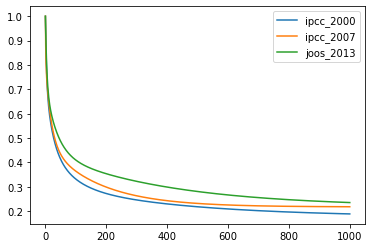

In [3]:
t_horizon = np.arange(1001)
ipcc_2000 = IRF(t_horizon, 'ipcc_2000')
ipcc_2007 = IRF(t_horizon, 'ipcc_2007')
joos_2013 = IRF(t_horizon, 'joos_2013')
plt.plot(t_horizon, ipcc_2000, label='ipcc_2000')
plt.plot(t_horizon, ipcc_2007, label='ipcc_2007')
plt.plot(t_horizon, joos_2013, label='joos_2013')
plt.legend()

Joos et al. (2013) report the following time-dependent fractions of an original pulse of CO2 remaining in the atmosphere in their results, section 4.1: 
- 0.6 +- 0.14 at year 20
- 0.4 +- 0.13 at year 100
- 0.25 +- 0.09 at year 1000

We can compare that to the joos_2013 curve we generated above: 

In [4]:
for curve in [joos_2013]:
    print('At t=20:   '+ str(round(curve[20],3)))
    print('At t=100:  '+ str(round(curve[100],3)))
    print('At t=1000: '+ str(round(curve[-1],3)))
    print()

At t=20:   0.596
At t=100:  0.409
At t=1000: 0.235



--> **Flag: what's going on at t=1000?** <--

# Ton-year accounting methods

Some terms for interpreting the three ton-year accounting methods implemented below

- *Baseline:* the curve atmospheric state-of affairs that is assumed to be the counterfaction to a project scenario
- *Baseline atmospheric impact:* the integral of the baseline curve
- *Scenario:* the curve representing what happens because of an intervention (could be representing carbon in a stock or carbon in the atmosphere depending on the method)
- *Benefit:* the reduction in atmospheric impact as a result of the scenario intervention 
- *Equivalence factor:* the ratio between the benefit and the atmospheric impact of a single tCO2 released at t=0 under shared assumptions


Some helper functions:

In [5]:
def discount(discount_rate, curve): 
    return [x/math.pow(1+discount_rate, i) for i,x in enumerate(curve)]

In [6]:
def print_benefit_report(method_output, plot):
    print()
    if method_output['discount_rate'] > 0: 
        baseline = method_output['baseline_discounted'] 
        scenario = method_output['scenario_discounted']
        baseline_atm_impact = method_output['baseline_atm_impact_discounted'] 
        benefit = method_output['benefit_discounted']
        equivalence = method_output['equivalence_factor']
    else: 
        baseline = method_output['baseline'] 
        scenario = method_output['scenario']
        baseline_atm_impact = method_output['baseline_atm_impact'] 
        benefit = method_output['benefit']
        equivalence = method_output['equivalence_factor_discounted']

    print('Baseline atmospheric impact: ' + str(round(baseline_atm_impact,2)) + ' ton-years')
    print('Benefit from delay: ' + str(round(benefit,2)) + ' ton-years')
    print('Equivalence factor: ' + str(round(benefit/baseline_atm_impact,2)) )

    print()
    if plot: 
        plot = plt.plot(baseline, label="baseline")
        plot = plt.plot(scenario, label="scenario")
        plot = plt.legend()

### Moura-Costa method

Method referenced IPCC Special report (2000) with outputs to check against: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

Method also described in Moura Costa and Wilson, 2000: https://oxfordclimatepolicy.org/sites/default/files/10.1023%252FA_1009697625521.pdf

In [7]:
def moura_costa(time_horizon, baseline, delay, scale, discount_rate):
    t = np.arange(time_horizon+1)
    baseline = baseline[0:time_horizon+1]
    scenario = [-scale]*(delay+1) + [0]*(time_horizon-(delay))               
    benefit = -np.trapz(scenario[:delay+1])
    baseline_atm_impact = np.trapz(baseline)
    equivalence_factor = benefit / baseline_atm_impact

    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = -np.trapz(scenario_discounted[:delay+1])
    baseline_atm_impact_discounted = np.trapz(baseline_discounted)
    equivalence_factor_discounted = benefit_discounted / baseline_atm_impact_discounted
    
    return {'t': t,
            'delay': delay,
            'discount_rate': discount_rate,
            'scenario': scenario, 
            'baseline': baseline, 
            'benefit': benefit, 
            'baseline_atm_impact': baseline_atm_impact, 
            'scenario_discounted': scenario_discounted,
            'baseline_discounted': baseline_discounted,
            'benefit_discounted': benefit_discounted, 
            'baseline_atm_impact_discounted': baseline_atm_impact_discounted,
            'equivalence_factor': equivalence_factor,
            'equivalence_factor_discounted': equivalence_factor_discounted}


Baseline atmospheric impact: 45.76 ton-years
Benefit from delay: 46.0 ton-years
Equivalence factor: 1.01



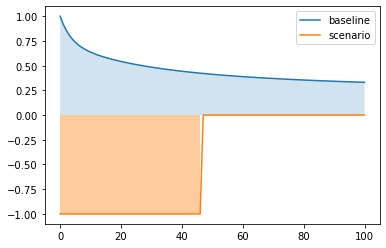

In [9]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
scale = 1
discount_rate = 0.0

m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(m, plot=True)

plot = plt.fill_between(m['t'], m['baseline'], alpha = 0.2)
plot = plt.fill_between(m['t'], m['scenario'], where=(np.array(m['scenario'])<0), alpha = 0.4)

Scenario = carbon stored outside of the atmosphere <br/>
Baseline = atmospheric carbon at t=0 <br/>
Benefit = (area under orange curve) <br/>
Equivalence factor = (benefit) / (area under blue curve) <br/>

### IPCC method 

Benefit == difference between the two atmospheric curves w/in the time horizon / "fraction of atmospheric perturbation remaining"

Method described IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

In [10]:
def ipcc(time_horizon, baseline, delay, scale=1, discount_rate=0):
    t = np.arange(time_horizon+1)
    baseline_unscaled = baseline[0:time_horizon+1]
    scenario = [0]*(delay+1) + baseline_unscaled[0:(time_horizon-(delay))]
    baseline = [b*scale for b in baseline_unscaled]
    scenario = [s*scale for s in scenario]
    if time_horizon < delay:
        scenario = scenario[:time_horizon+1]
    benefit = np.trapz(baseline) - np.trapz(scenario[delay+1:])
    baseline_atm_impact = np.trapz(baseline_unscaled) 
    equivalence_factor = benefit / baseline_atm_impact
       
    baseline_unscaled_discounted = discount(discount_rate, baseline_unscaled)
    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = np.trapz(baseline_discounted) - np.trapz(scenario_discounted[delay+1:])
    baseline_atm_impact_discounted = np.trapz(baseline_unscaled_discounted)
    equivalence_factor_discounted = benefit_discounted / baseline_atm_impact_discounted
    
    return {'t': t,
            'delay': delay,
            'discount_rate': discount_rate,
            'baseline': baseline,
            'baseline_discounted': baseline_discounted,
            'baseline_atm_impact': baseline_atm_impact, 
            'baseline_atm_impact_discounted': baseline_atm_impact_discounted,
            'scenario': scenario, 
            'scenario_discounted': scenario_discounted,
            'benefit': benefit, 
            'benefit_discounted': benefit_discounted, 
            'equivalence_factor': equivalence_factor,
            'equivalence_factor_discounted': equivalence_factor_discounted
           }


Baseline atmospheric impact: 45.76 ton-years
Benefit from delay: 17.04 ton-years
Equivalence factor: 0.37



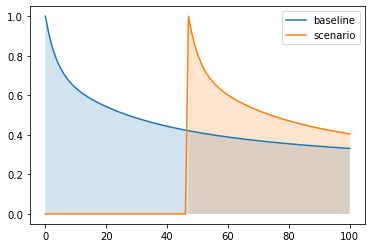

In [11]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
scale = 1
discount_rate = 0.0

i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(i, plot=True)
plot = plt.fill_between(i['t'], i['baseline'], alpha=0.2) 
plot = plt.fill_between(i['t'], i['scenario'], where=(i['t']>=delay+1), alpha=0.2) 

Scenario = atmospheric carbon released with delay <br/>
Baseline = atmospheric carbon released at t=0 <br/>
Benefit = (area under blue curve) - (area under orange curve) <br/>
Equivalence factor = (benefit) / (area under blue curve)<br/>
If scale > 1, benefit is calculated w.r.t. a "scaled" baseline curve while equivalence factor is  calculated w.r.t. scale=1

### Lashof method

Method referenced IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

And described in Fearnside, Lashof & Moura-Costa, 2000: https://link.springer.com/article/10.1023%2FA%3A1009625122628

In [12]:
def lashof(time_horizon, baseline, delay, scale=1, discount_rate=0): 
    t = np.arange(time_horizon + delay + 1)
    baseline = baseline[0:time_horizon+1] 
    scenario = [0]* delay + baseline
    scenario = [s*scale for s in scenario]
    benefit = np.trapz(scenario[time_horizon-1:])
    baseline_atm_impact = np.trapz(baseline)
    equivalence_factor = benefit / baseline_atm_impact

    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = np.trapz(scenario_discounted[time_horizon-1:])
    baseline_atm_impact_discounted = np.trapz(baseline_discounted)
    equivalence_factor_discounted = benefit_discounted / baseline_atm_impact_discounted

    return {'t': t,
            'delay': delay,
            'discount_rate': discount_rate,
            'scenario': scenario, 
            'baseline': baseline, 
            'benefit': benefit, 
            'baseline_atm_impact': baseline_atm_impact, 
            'scenario_discounted': scenario_discounted,
            'baseline_discounted': baseline_discounted,
            'benefit_discounted': benefit_discounted, 
            'baseline_atm_impact_discounted': baseline_atm_impact_discounted,
            'equivalence_factor': equivalence_factor,
            'equivalence_factor_discounted': equivalence_factor_discounted}


Baseline atmospheric impact: 45.76 ton-years
Benefit from delay: 17.04 ton-years
Equivalence factor: 0.37



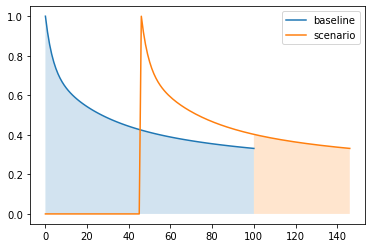

In [13]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
scale = 1
discount_rate = 0.0

l = lashof(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(l, plot=True)
plot = plt.fill_between(l['t'][:len(l['baseline'])], l['baseline'], alpha = 0.2)
plot = plt.fill_between(l['t'], l['scenario'], where=(l['t']>=time_horizon), alpha = 0.2)

Scenario = atmospheric carbon released with delay <br/>
Baseline = atmospheric carbon released at t=0 <br/>
Benefit = (area under orange curve hanging past the time horizon) <br/>
Equivalence factor = (benefit) / (area under blue curve)<br/>

# Methods x Time Horizon

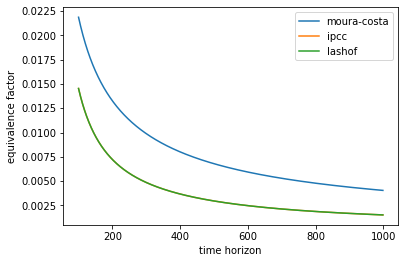

In [14]:
#time_horizon = 100
delay = 1
baseline = ipcc_2000
scale = 1
discount_rate = 0

t = np.arange(100,1000)
equivalence_m = []
equivalence_i = []
equivalence_l = []
for time_horizon in t:
    m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
    l = lashof(time_horizon, baseline, delay, scale, discount_rate)
    equivalence_m.append(m['equivalence_factor'])  
    equivalence_i.append(i['equivalence_factor']) 
    equivalence_l.append(l['equivalence_factor'])
    
plt.plot(t, equivalence_m, label="moura-costa")
plt.plot(t, equivalence_i, label="ipcc")
plt.plot(t, equivalence_l, label="lashof")
plt.xlabel('time horizon')
plt.ylabel('equivalence factor')
plt.legend()

# Methods x Discounting

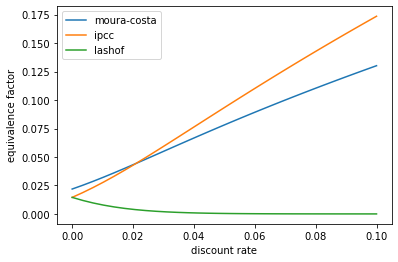

In [15]:
time_horizon = 100
delay = 1
baseline = ipcc_2000
scale = 1
#discount_rate = 0

d = np.linspace(0, 0.1, 30)
equivalence_m = []
equivalence_i = []
equivalence_l = []

for discount_rate in d:
    m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
    l = lashof(time_horizon, baseline, delay, scale, discount_rate)
    equivalence_m.append(m['equivalence_factor_discounted'])  
    equivalence_i.append(i['equivalence_factor_discounted']) 
    equivalence_l.append(l['equivalence_factor_discounted'])
    
plt.plot(d, equivalence_m, label="moura-costa")
plt.plot(d, equivalence_i, label="ipcc")
plt.plot(d, equivalence_l, label="lashof")
plt.xlabel('discount rate')
plt.ylabel('equivalence factor')
plt.legend()

# Methods x Delay

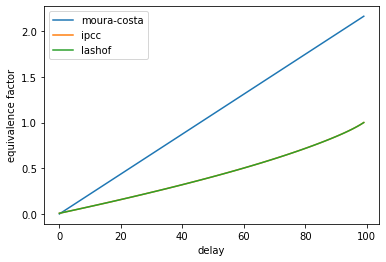

In [16]:
time_horizon = 100
#delay = 1
baseline = ipcc_2000
scale = 1
discount_rate = 0

d = np.arange(100)
equivalence_m = []
equivalence_i = []
equivalence_l = []
for delay in d:
    m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
    l = lashof(time_horizon, baseline, delay, scale, discount_rate)
    equivalence_m.append(m['equivalence_factor'])  
    equivalence_i.append(i['equivalence_factor']) 
    equivalence_l.append(l['equivalence_factor'])
    
plt.plot(d, equivalence_m, label="moura-costa")
plt.plot(d, equivalence_i, label="ipcc")
plt.plot(d, equivalence_l, label="lashof")
plt.xlabel('delay')
plt.ylabel('equivalence factor')
plt.legend()

# Methods x (Scale / Delay)

Is keeping 1 ton out of the atmosphere for 46 years the same thing as keeping 46 tons out of the atmosphere for 1 year according to all methods?

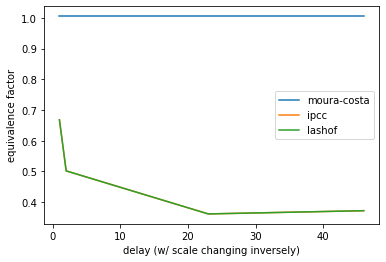

In [17]:
time_horizon = 100
#delay = 46
baseline = ipcc_2000
#scale = 1
discount_rate = 0

d = [1, 2, 23, 46]
s = [46, 23, 2, 1]
equivalence_m = []
equivalence_i = []
equivalence_l = []
for i, delay in enumerate(d):
    scale = s[i]
    m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
    l = lashof(time_horizon, baseline, delay, scale, discount_rate)
    equivalence_m.append(m['equivalence_factor'])  
    equivalence_i.append(i['equivalence_factor']) 
    equivalence_l.append(l['equivalence_factor'])
    
plt.plot(d, equivalence_m, label="moura-costa")
plt.plot(d, equivalence_i, label="ipcc")
plt.plot(d, equivalence_l, label="lashof")
plt.xlabel('delay (w/ scale changing inversely)')
plt.ylabel('equivalence factor')
plt.legend()

# Case Study: NCX 

Moura-costa method? 

- Time horizon: 100 years
- 1 tCO2e equivalency: 48 ton-years, citing IPCC 2007
- Discount rate: 3.3% → 17 ton-years today = 48 ton-years over 100 year

See "Forest and Carbon: A Guide for Buyers and Policymakers", p.21-24 for a description of the NCX ton-year accounting method: https://ncx.com/wp-content/uploads/2021/06/Forests-and-Carbon_A-Guide-for-Buyers-and-Policymakers_SilviaTerra2020_v0.4-2-1.pdf 

In [23]:
time_horizon = 100
baseline = ipcc_2007
delay = 1
scale = 17
discount_rate = 0.033

ncx = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(ncx, plot=False)


Baseline atmospheric impact: 17.18 ton-years
Benefit from delay: 16.73 ton-years
Equivalence factor: 0.97



### Cost sensitivity

Imagine the cost carbon credit is $10/permanent ton, where a 'permanent ton' is a handful of ton-years packaged up according to the NCX methodology modeled above. Since a 'permanent ton' = 17 ton-years, we can say that each ton-year costs 59 cents. 

In [24]:
ton_year_cost = 10/17
round(ton_year_cost,2)

0.59


If the cost of a ton-year reflects a true cost of taking an action today, we can then ask how the cost of a buying a 'permanent ton' via ton-years today changes as we change the method (from moura costa to lashof) or the parameters (discount rate, time horizon). 

Using the same method and parameters but changing the discount rate from 0% to 5% results in a **3.5x price swing**:

In [29]:
time_horizon = 100
delay = 1
scale = 1
#discount_rate = 0.033
baseline = ipcc_2007

for discount_rate in [0, 0.02, 0.033, 0.05]:
    ncx = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    equivalence = ncx['equivalence_factor_discounted']
    print('Discount rate: ' + str(discount_rate))
    print('Ton-years needed today: '+ str(round(ncx['baseline_atm_impact_discounted'])))
    print('Cost of permanent ton: $' + str(round(ton_year_cost * (1/equivalence))))
    print()

Discount rate: 0
Ton-years needed today: 48
Cost of permanent ton: $28

Discount rate: 0.02
Ton-years needed today: 24
Cost of permanent ton: $14

Discount rate: 0.033
Ton-years needed today: 17
Cost of permanent ton: $10

Discount rate: 0.05
Ton-years needed today: 13
Cost of permanent ton: $8



If the discount rate were zero, varying the time horizon (100-1000 years) results in **5x price swing**. 
If instead the discount rate is 3.3, as in the NCX methodology, varying the time horizon (100-1000 years) results in **0.1x price swing**. 

In [32]:
#time_horizon = 100
delay = 1
scale = 1
discount_rate = 0.033
baseline = ipcc_2007

for time_horizon in [100, 1000]:
    ncx = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
    equivalence = ncx['equivalence_factor_discounted']
    print('Time horizon: ' + str(time_horizon))
    print('Ton-years needed today: '+ str(round(ncx['baseline_atm_impact_discounted'])))
    print('Cost of permanent ton: $' + str(round(ton_year_cost * (1/equivalence))))
    print()

Time horizon: 100
Ton-years needed today: 17
Cost of permanent ton: $10

Time horizon: 1000
Ton-years needed today: 18
Cost of permanent ton: $11



Using the same parameters but varying the method results in a **35x price swing**.

(Note the disparate impact discount rates on the different methods - see above!):

In [31]:
time_horizon = 100
delay = 1
scale = 1
discount_rate = 0.0
baseline = ipcc_2007

ncx_m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
ncx_i = ipcc(time_horizon, baseline, delay, scale, discount_rate)
ncx_l = lashof(time_horizon, baseline, delay, scale, discount_rate)

for i,ncx in enumerate([ncx_m, ncx_i, ncx_l]):
    print(['MOURA_COSTA','IPCC', 'LASHOF'][i])
    equivalence = ncx['equivalence_factor_discounted']
    print('Ton-years needed today: '+ str(round(ncx['baseline_atm_impact_discounted'])))
    print('Cost of permanent ton: $' + str(round(ton_year_cost * (1/equivalence))))
    print()

MOURA_COSTA
Ton-years needed today: 48
Cost of permanent ton: $28

IPCC
Ton-years needed today: 48
Cost of permanent ton: $39

LASHOF
Ton-years needed today: 48
Cost of permanent ton: $39

